#### Imports

In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plotting library
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.activations import sigmoid
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix

#### Model Configuration

In [42]:
#---------------------------------------------------------------------
#Function to create the default configuration for the model. This will be overridden as
#required during experimentation
#---------------------------------------------------------------------
def base_model_config():
    model_config = {
            "HIDDEN_NODES" : 64,
            "HIDDEN_ACTIVATION" : "relu",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "adam",
            "LEARNING_RATE" : 0.001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.2,
            "EPOCHS" : 10,
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.5,
            "VERBOSE" : 0,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"],
            "EMBEDDING_OUTPUT": 100
            }
    return model_config

#### Helper Functions

In [43]:
#---------------------------------------------------------------------
# Function to create an optimizer based on the optimizer name and learning rate
#---------------------------------------------------------------------
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None

    if optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    elif'adam' :
        optimizer = Adam(learning_rate=learning_rate)

    else :
        optimizer = SGD(learning_rate=learning_rate)

    return optimizer

In [44]:
def get_model(model_config,X,model_name):
    model=tf.keras.models.Sequential(name=model_name)

    model.add(Embedding(5000,
                        model_config["EMBEDDING_OUTPUT"],
                        input_length=2031))
    model.add(Flatten())
    
    model.add(Dense(model_config["HIDDEN_NODES"],
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
    
    model.add(Dropout(model_config["DROPOUT_RATE"]))

    model.add(Dense(1,
                    name="Output-Layer",
                    activation=sigmoid))

    optimizer = get_optimizer(model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])

    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                  metrics=model_config["METRICS"])
    return model

In [45]:
#---------------------------------------------------------------------
# Function to create a model and fit the model
#---------------------------------------------------------------------

def create_and_run_model(model_config,X,Y,model_name) :

    model = get_model(model_config,X,model_name)

    print("\n******************************************************")
    model.summary()

    X_train, X_val, Y_train, Y_val =train_test_split(
                        X,Y,
                        stratify=Y,
                        test_size=model_config["VALIDATION_SPLIT"])

    history=model.fit(X_train,
          Y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          verbose=model_config["VERBOSE"],
          validation_data= (X_val, Y_val))

    return history,model

In [46]:
def get_score(model, X_test, Y_test):
     score = model.evaluate(X_test, Y_test, verbose=False)
     return score

In [47]:
#---------------------------------------------------------------------
#Function to plot a graph based on the results derived
#---------------------------------------------------------------------
def plot_graph(accuracy_measures, title):
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

#### Load Data

In [48]:
data = pd.read_csv('../fake_job_postings.csv')
text = data['description'].astype(str)
labels = data['fraudulent']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
max_length = max([len(s) for s in sequences])
data = pad_sequences(sequences, maxlen=max_length)
data.shape, max_length

((17880, 2031), 2031)

#### Train-Test Split

In [49]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

#### Optimize Batch Size

In [50]:
accuracy_measures = {}

for batch_size in range(16,128,16):

    #Load default configuration
    model_config = base_model_config()
    #Acquire and process input data

    #set epoch to 100
    model_config["EPOCHS"]=10
    #Set batch size to experiment value
    model_config["BATCH_SIZE"] = batch_size
    model_name = "Batch-Size-" + str(batch_size)
    history, model=create_and_run_model(model_config, x_train, y_train, model_name)

    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Batch-Size-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2031, 100)         500000    
                                                                 
 flatten_3 (Flatten)         (None, 203100)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                12998464  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
___________________________________________________

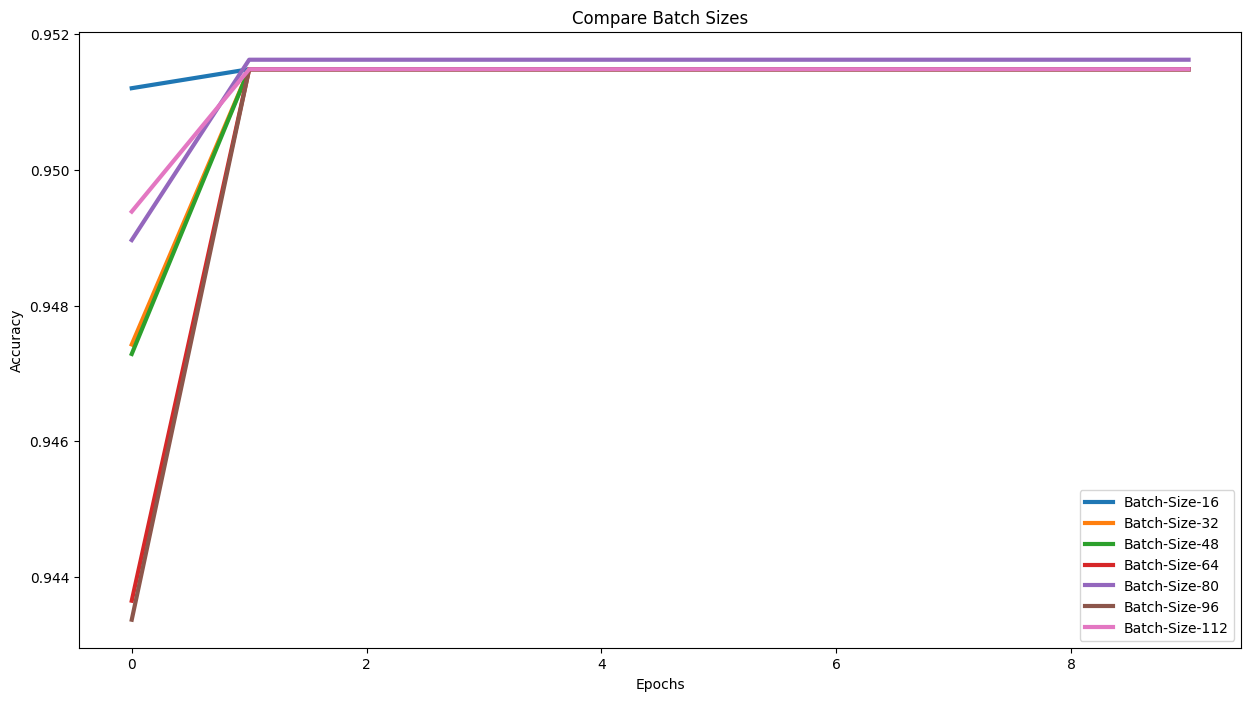

In [51]:
plot_graph(accuracy_measures, "Compare Batch Sizes")

Best Batch Size: 80

#### Optimize Activation Function

In [54]:
accuracy_measures = {}

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model-" + activation
    history, model =create_and_run_model(model_config,x_train,y_train,model_name)

    accuracy_measures["Model-" + activation] = history.history["accuracy"]


******************************************************
Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_12 (Flatten)        (None, 203100)            0         
                                                                 
 dense_12 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
______________________________________________________

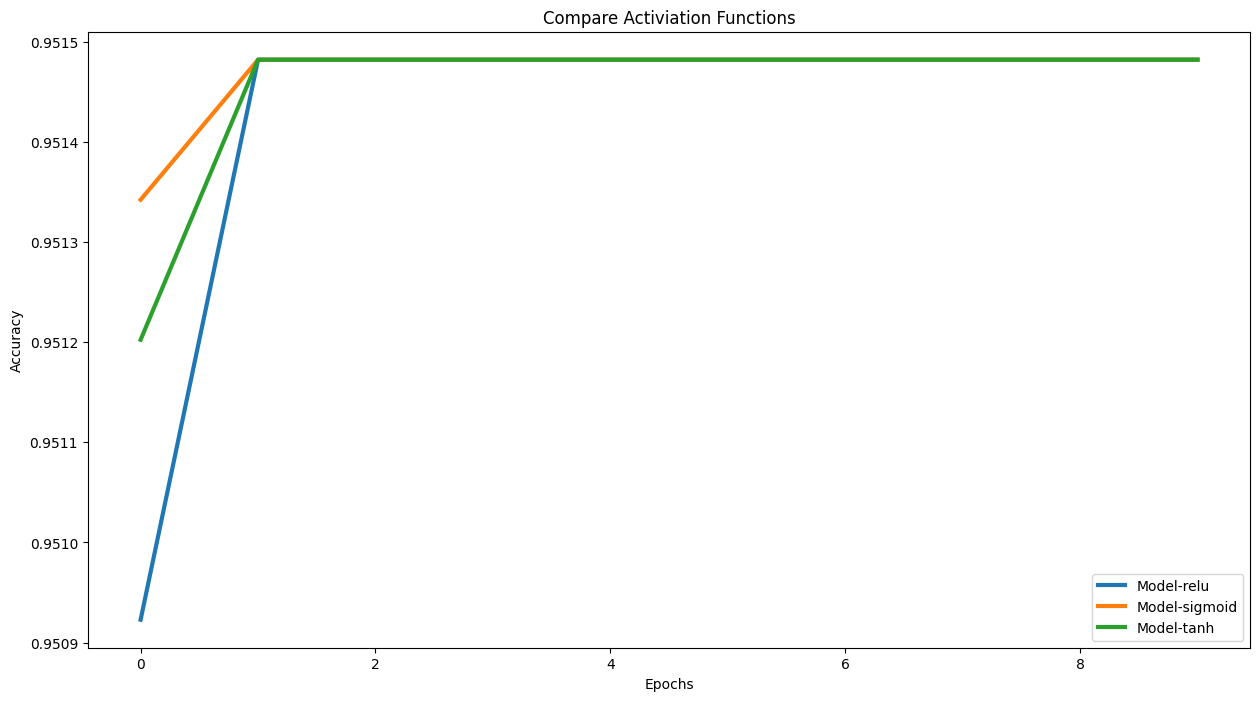

In [55]:
plot_graph(accuracy_measures, "Compare Activiation Functions")

#### Optimize Initial Weights

In [56]:
accuracy_measures = {}

initializer_list = ['random_normal','zeros','ones',"random_uniform"]
for initializer in initializer_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    # set activation to
    model_config["HIDDEN_ACTIVATION"] = 'relu'
    model_config["WEIGHTS_INITIALIZER"] = initializer
    model_name = "Model-" + initializer
    history, model =create_and_run_model(model_config,x_train,y_train, model_name)

    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_15 (Flatten)        (None, 203100)            0         
                                                                 
 dense_15 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
_____________________________________________

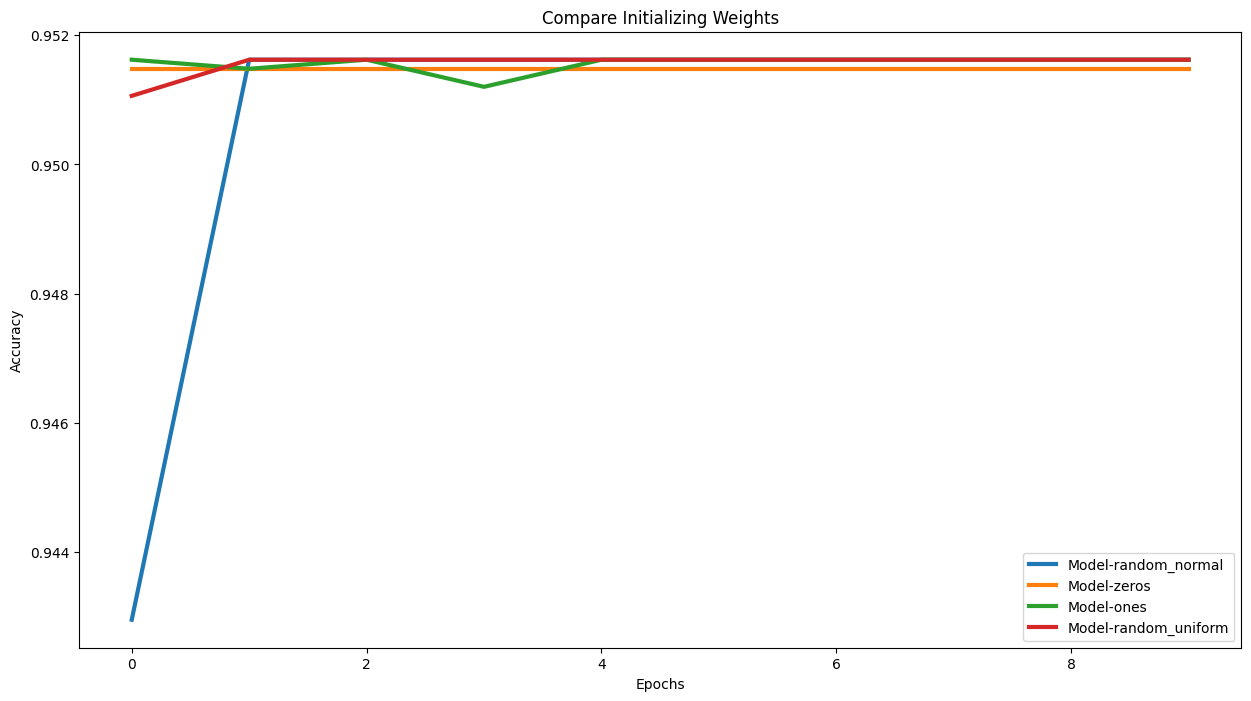

In [57]:
plot_graph(accuracy_measures, "Compare Initializing Weights")

#### Optimize Optimizers

In [58]:
accuracy_measures = {}

optimizer_list = ['sgd','rmsprop','adam','adagrad']
for optimizer in optimizer_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    # set activation to
    model_config["HIDDEN_ACTIVATION"] = 'relu'
    # set initilaizer to 'random_normal'
    model_config["WEIGHTS_INITIALIZER"] = 'random_normal'
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history, model =create_and_run_model(model_config,x_train,y_train, model_name)

    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_19 (Flatten)        (None, 203100)            0         
                                                                 
 dense_19 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
___________________________________________________

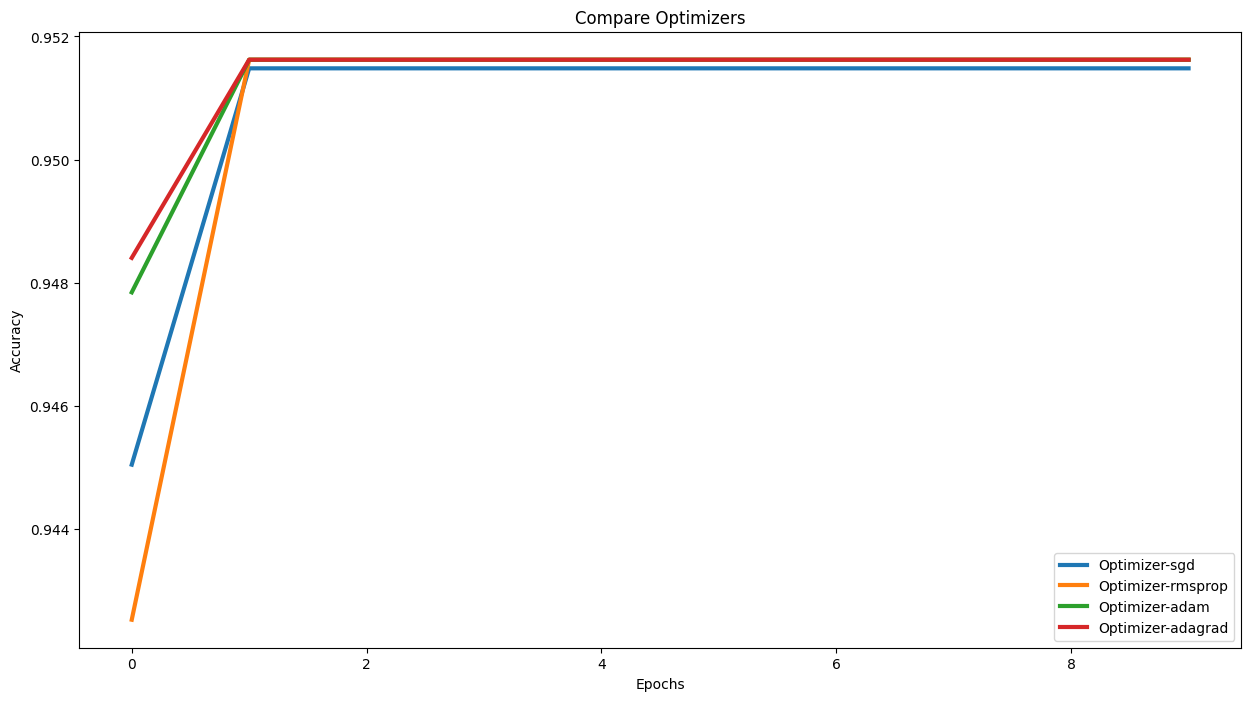

In [59]:
plot_graph(accuracy_measures, "Compare Optimizers")

#### Optimimze Learning Rates

In [60]:
accuracy_measures = {}

learning_rate_list = [0.001,0.01,0.1]
for learning_rate in learning_rate_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    # set activation to
    model_config["HIDDEN_ACTIVATION"] = 'relu'
    # set initilaizer to 'random_normal'
    model_config["WEIGHTS_INITIALIZER"] = 'random_normal'
    #Fix Optimizer to the one chosen above
    model_config["OPTIMIZER"]="adam"
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history, model =create_and_run_model(model_config,x_train,y_train, model_name)

    #Using validation accuracy
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_23 (Flatten)        (None, 203100)            0         
                                                                 
 dense_23 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
_____________________________________________

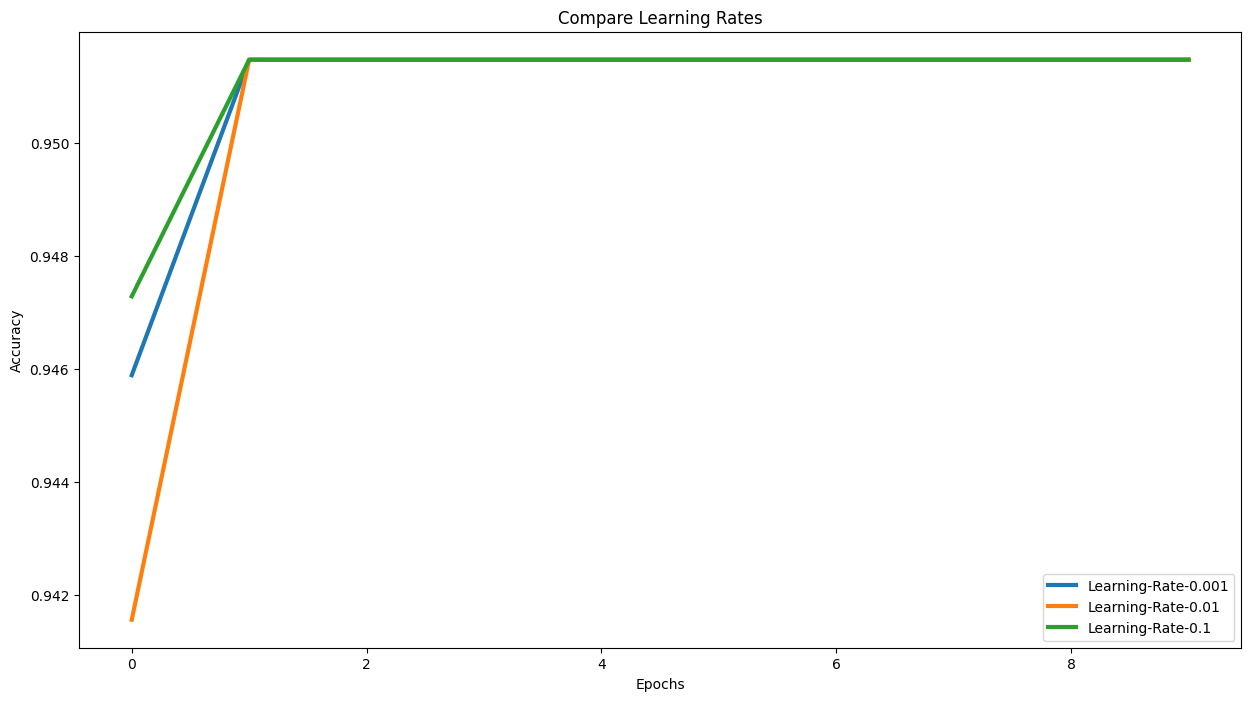

In [61]:
plot_graph(accuracy_measures, "Compare Learning Rates")

#### Optimize Regularization

In [62]:
accuracy_measures = {}

regularizer_list = [None,'l1','l2']
for regularizer in regularizer_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    # set activation to
    model_config["HIDDEN_ACTIVATION"] = 'relu'
    # set initilaizer to 'random_normal'
    model_config["WEIGHTS_INITIALIZER"] = 'random_normal'
    #Fix Optimizer to the one chosen above
    model_config["OPTIMIZER"]="adam"
    # set learning rate to
    model_config["LEARNING_RATE"] = 0.001
    model_config["REGULARIZER"] = regularizer
    model_name = "Regularizer-" + str(regularizer)
    history, model =create_and_run_model(model_config,x_train,y_train, model_name)

    #Switch to validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_26 (Flatten)        (None, 203100)            0         
                                                                 
 dense_26 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
________________________________________________

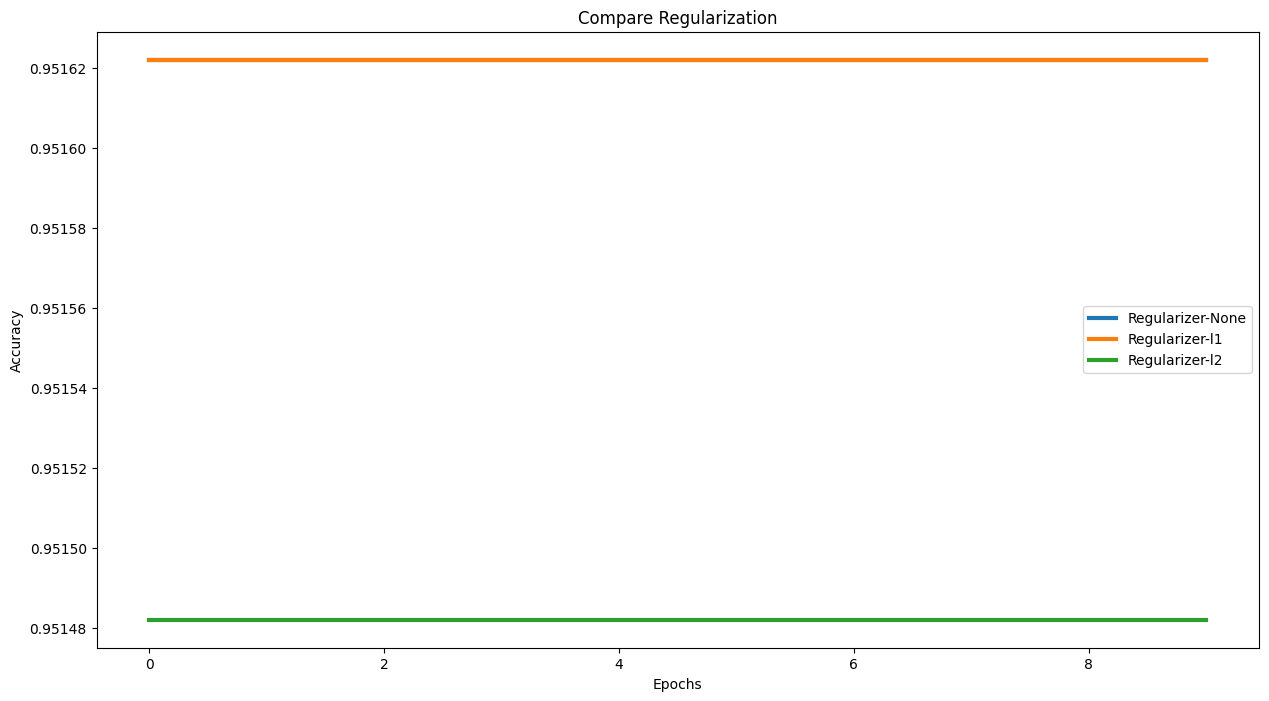

In [63]:
plot_graph(accuracy_measures, "Compare Regularization")

#### Optimize Dropout

In [65]:
accuracy_measures = {}

dropout_list = [0.2, 0.35, 0.5]
best_score = 0
for dropout in dropout_list:

    model_config = base_model_config()

    #set epoch to 100
    model_config["EPOCHS"]=10
    # set batch_size to 112
    model_config["BATCH_SIZE"] = 80
    # set hidden nodes to 80
    model_config["HIDDEN_NODES"] = 64
    # set activation to
    model_config["HIDDEN_ACTIVATION"] = 'relu'
    # set initilaizer to 'random_normal'
    model_config["WEIGHTS_INITIALIZER"] = 'random_normal'
    #Fix Optimizer to the one chosen above
    model_config["OPTIMIZER"]="adam"
    # set learning rate to
    model_config["LEARNING_RATE"] = 0.001
    # set learning rate to
    model_config["REGULARIZER"] = 'l1'
    model_config["DROPOUT_RATE"] = dropout
    model_name="Dropout-" + str(dropout)
    history, model=create_and_run_model(model_config,x_train,y_train, model_name)
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Dropout-0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_30 (Flatten)        (None, 203100)            0         
                                                                 
 dense_30 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
_____________________________________________________

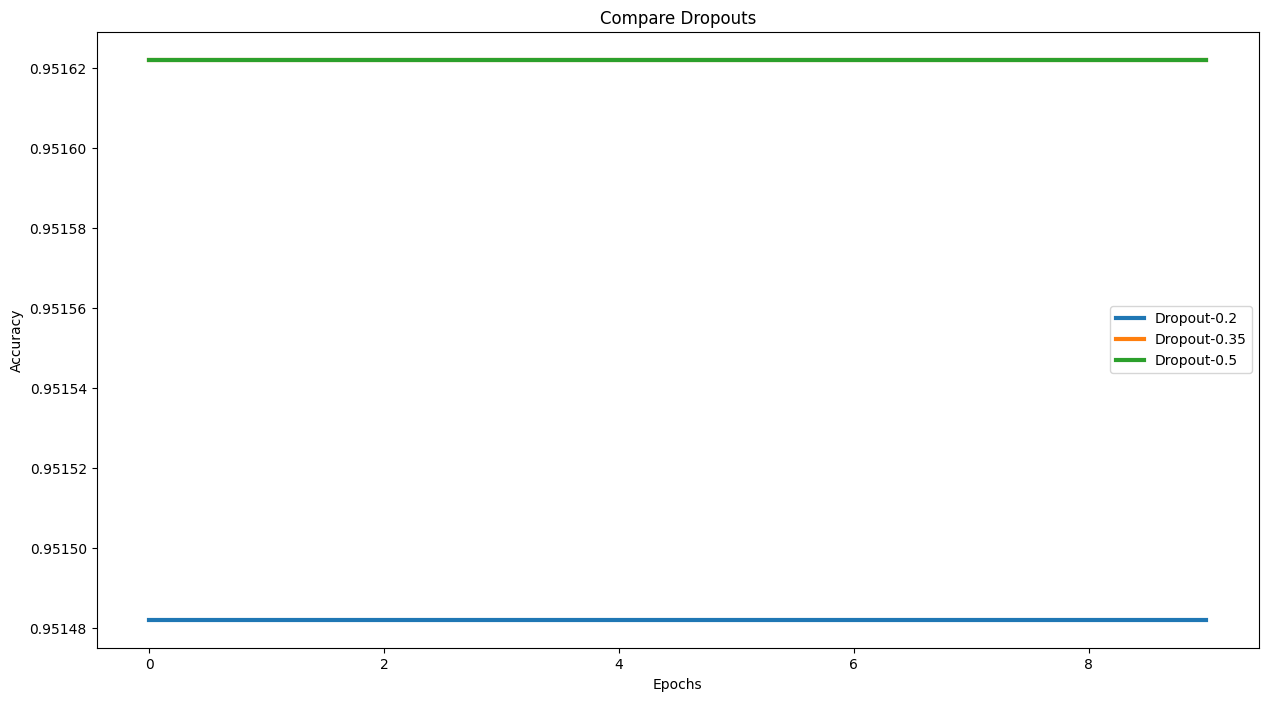

In [66]:
plot_graph(accuracy_measures, "Compare Dropouts")

#### First Model vs. Optimized Model

base model (first model)

In [69]:
accuracy_measures = {}
loss_score = {}
accuracy_score = {}

###Base Minimal Model ####
model_config = base_model_config()
model_config["EPOCHS"]=10
model_config["HIDDEN_NODES"] = 16
model_config["DROPOUT_RATE"] = 0.7
model_config["OPTIMIZER"]="sgd"
model_config["LEARNING_RATE"] = 0.0001

model_name = "Base-Model"

history, model=create_and_run_model(model_config,x_train,y_train,model_name)
score = get_score(model,x_test,y_test)

accuracy_measures[model_name] = history.history["accuracy"]
loss_score[model_name] = score[0]
accuracy_score[model_name] = score[1]


******************************************************
Model: "Base-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_35 (Flatten)        (None, 203100)            0         
                                                                 
 dense_35 (Dense)            (None, 16)                3249616   
                                                                 
 dropout_32 (Dropout)        (None, 16)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 3,749,633
Trainable params: 3,749,633
Non-trainable params: 0
________________________________________________________

optimized model

In [70]:
### OPTIMIZED MODEL ####
#Adding all optimizations
model_config = base_model_config()
#set epoch to 100
model_config["EPOCHS"]=10
# set batch_size to 112
model_config["BATCH_SIZE"] = 80
# set hidden nodes to 80
model_config["HIDDEN_NODES"] = 64
# set activation to relu
model_config["HIDDEN_ACTIVATION"] = 'relu'
# set initilaizer to 'random_normal'
model_config["WEIGHTS_INITIALIZER"] = 'random_normal'
#Fix Optimizer to the one chosen above
model_config["OPTIMIZER"]="adam"
# set learning rate to 0.05
model_config["LEARNING_RATE"] = 0.001
# set learning rate to
model_config["REGULARIZER"] = "l1"
# fix drop out to 0.2
model_config["DROPOUT_RATE"] = 0.5

model_name = "Optimized-Model"

history, model=create_and_run_model(model_config,x_train,y_train,model_name)
score = get_score(model,x_test,y_test)

accuracy_measures[model_name] = history.history["accuracy"]
loss_score[model_name] = score[0]
accuracy_score[model_name] = score[1]


******************************************************
Model: "Optimized-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 2031, 100)         500000    
                                                                 
 flatten_36 (Flatten)        (None, 203100)            0         
                                                                 
 dense_36 (Dense)            (None, 64)                12998464  
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 13,498,529
Trainable params: 13,498,529
Non-trainable params: 0
_________________________________________________

Plot Optimiziation

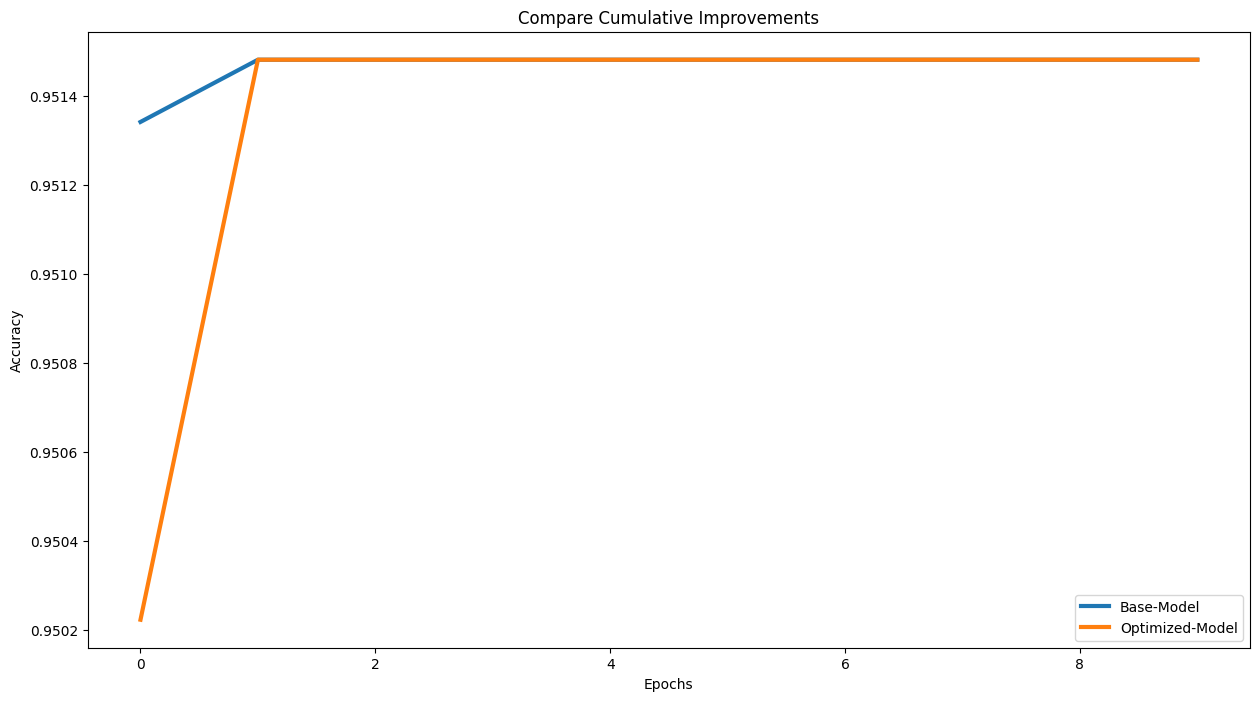

In [71]:
plot_graph(accuracy_measures, "Compare Cumulative Improvements")

In [74]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

112/112 [==============================] - 1s 12ms/step


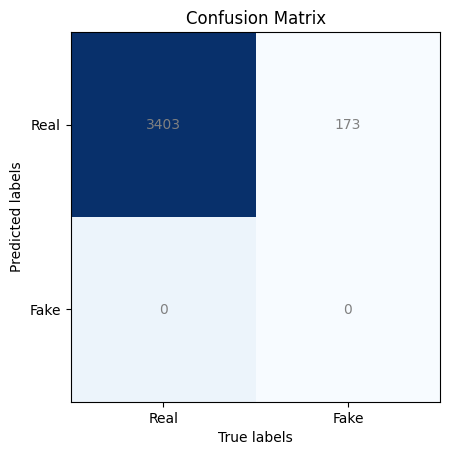

In [75]:
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.yticks([0, 1], ['Real', 'Fake'])
plt.text(0, 0, cm[0,0], ha="center", va="center", color="grey")
plt.text(0, 1, cm[0,1], ha="center", va="center", color="grey")
plt.text(1, 0, cm[1,0], ha="center", va="center", color="grey")
plt.text(1, 1, cm[1,1], ha="center", va="center", color="grey")
plt.show()